In [24]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import glob
import os
import glob




def loadFile(name):
    data=pd.read_csv(name,sep="\t")
    data["H"]=np.round(data["B_extx (T)"]*10000/(np.sqrt(2)/2))
    data["m_full"]=(data["m_fullx (A/m)"]+data["m_fully (A/m)"])/np.sqrt(2)
    data["m"]=data["m_full"]/np.max(np.abs(data["m_full"]))

    try: 
        data["hIsland_my"]=data["m_full.region1y (A/m)"]/np.max(np.sqrt(data["m_full.region1y (A/m)"]**2+data["m_full.region1x (A/m)"]**2))
    except Exception:
        pass
    

    data=data.drop(columns=["# t (s)",\
    "mz ()","mx ()", "my ()",\
    "B_extx (T)", "B_exty (T)","B_extz (T)",\
    "m_fullz (A/m)","m_fullx (A/m)","m_fully (A/m)",\
    "m_full.region1x (A/m)","m_full.region1y (A/m)","m_full.region1z (A/m)",\
    "m_full.region2x (A/m)","m_full.region2y (A/m)","m_full.region2z (A/m)"])

    try:
        data.attrs["Hc"]=np.average(np.abs(data[np.sign(data["m"]).diff() != 0]["H"].iloc[1:]))
        data.attrs["Br"]=np.average(np.abs(data[np.sign(data["H"]).diff() != 0]["m"].iloc[1:]))
    except Exception:
        pass


    return data

def decodeAttributes(string):
    dict={}
    desc=string.split(";")
    for attribute in desc:
        dict[attribute[0]] = float(attribute[1:])
    return dict

def getPossibleVals(data):
    pointinessVals=[]
    spacingVals=[]
    lengthVals=[]
    resVals=[]
    for i in data:
        if round(i.attrs["pointiness"],5) not in pointinessVals: pointinessVals.append(round(i.attrs["pointiness"],5))
        if i.attrs["length"] not in lengthVals: lengthVals.append(i.attrs["length"])
        if i.attrs["spacing"] not in spacingVals: spacingVals.append(i.attrs["spacing"])
        if i.attrs["res"] not in resVals: resVals.append(i.attrs["res"])

    pointinessVals.sort()
    spacingVals.sort()
    lengthVals.sort()
    resVals.sort()

    return pointinessVals, spacingVals, lengthVals, resVals

def getRuns(spacing,pointiness,length):
    minDist=None
    bestRun=None

    runs=[]
    for run in data:
        dist=abs(run.attrs["spacing"]-spacing)*1e9+abs(run.attrs["pointiness"]-pointiness)*100+abs(run.attrs["length"]-length)*1e9
        if dist<0.01:
            runs.append(run)
    
    return runs



data=[]
filePrefix="resolutionTest/"
for name in glob.glob(filePrefix+"*.out"):
    try:
        thisData=loadFile(name+"/table.txt")
    except Exception:
        print(f"Could not load {name}")
        continue
    desc=name[len(filePrefix):-len(".out")]

    attrs = decodeAttributes(desc)
    pointiness, spacing, length, runNum = attrs["p"], attrs["a"], attrs["l"], attrs["s"]

    thisData.attrs["pointiness"]=pointiness
    thisData.attrs["spacing"]=spacing
    thisData.attrs["length"]=length
    thisData.attrs["runNum"]=runNum
    thisData.attrs["res"]=attrs["r"]

    data.append(thisData)

pointinessVals, spacingVals, lengthVals, resVals = getPossibleVals(data)
print(getPossibleVals(data))



([0.1, 0.5, 0.9], [3.2e-07, 5.12e-07], [1.8000000000000002e-07, 2.3000000000000002e-07, 3.0000000000000004e-07], [1e-09, 2e-09, 4e-09])


In [25]:
def indexOfSame(arr):
    if arr[0]==arr[1] or arr[0]==arr[2]:
        return 0
    if arr[1] == arr[2]:
        return 1

def selectRunIndex(runs):
    Brs = np.array([run.attrs["Br"] for run in runs])
    Hcs = np.array([run.attrs["Hc"] for run in runs])
    Mys = np.array([min(run["hIsland_my"]) for run in runs])

    allAgree=True
    selectedI=None
    for i in [0,1,2]:
        for j in [0,1,2]:
            if i==j: continue

            if(abs(Brs[i]-Brs[j])<0.001 and abs(Hcs[i]-Hcs[j])<1 and abs(Mys[i]-Mys[j]) < 0.001):
                selectedI=i
            else:
                allAgree=False
    
    return allAgree, selectedI



def removeDuplicateRuns(data):
    newData=[]
    numFixes=0
    totalRunCount=0
    unfixable=0
    insufficientTrials=0

    for pointiness in pointinessVals:
        for spacing in spacingVals:
            for length in lengthVals:
                runs=getRuns(spacing,pointiness,length)
                if len(runs)<3:
                    if len(runs)>0:
                        print(pointiness,spacing,length)
                        insufficientTrials+=1
                    continue
                if len(runs)>3:
                    runs=runs[0:3]

                    
                totalRunCount+=1


                Brs = np.array([run.attrs["Br"] for run in runs])
                Hcs = np.array([run.attrs["Hc"] for run in runs])
                Mys = np.array([min(run["hIsland_my"]) for run in runs])

                
                
                allAgree, i = selectRunIndex(runs)

                if not allAgree: numFixes += 1

                if i is None:
                    print(f"Inconsistent data for {pointiness}, {spacing}, {length}")
                    unfixable+=1
                    continue

                newData.append(runs[i])

    print(f"Fixed data for {numFixes}/{totalRunCount} runs. {unfixable} runs unfixable, {insufficientTrials} not enough data")
    return newData



                



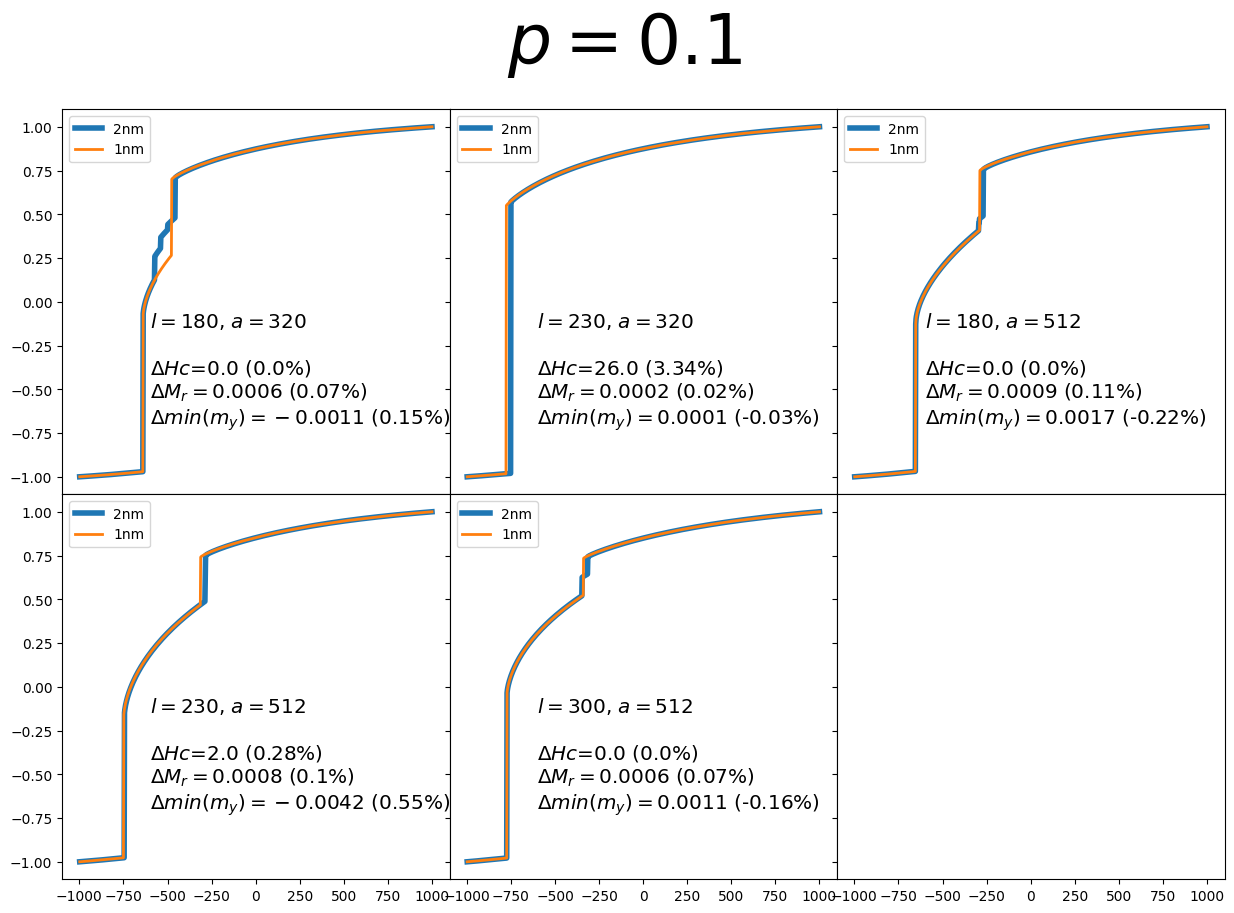

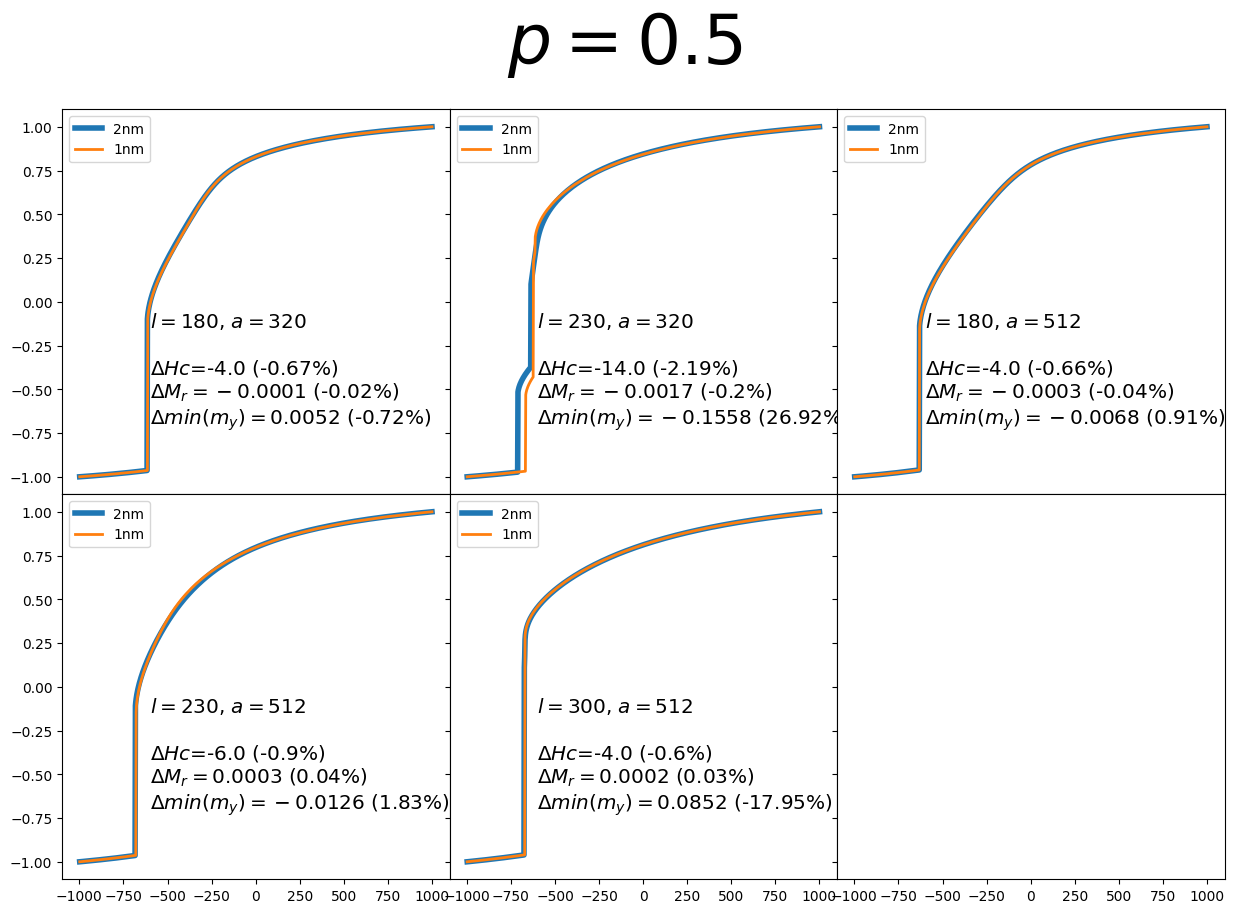

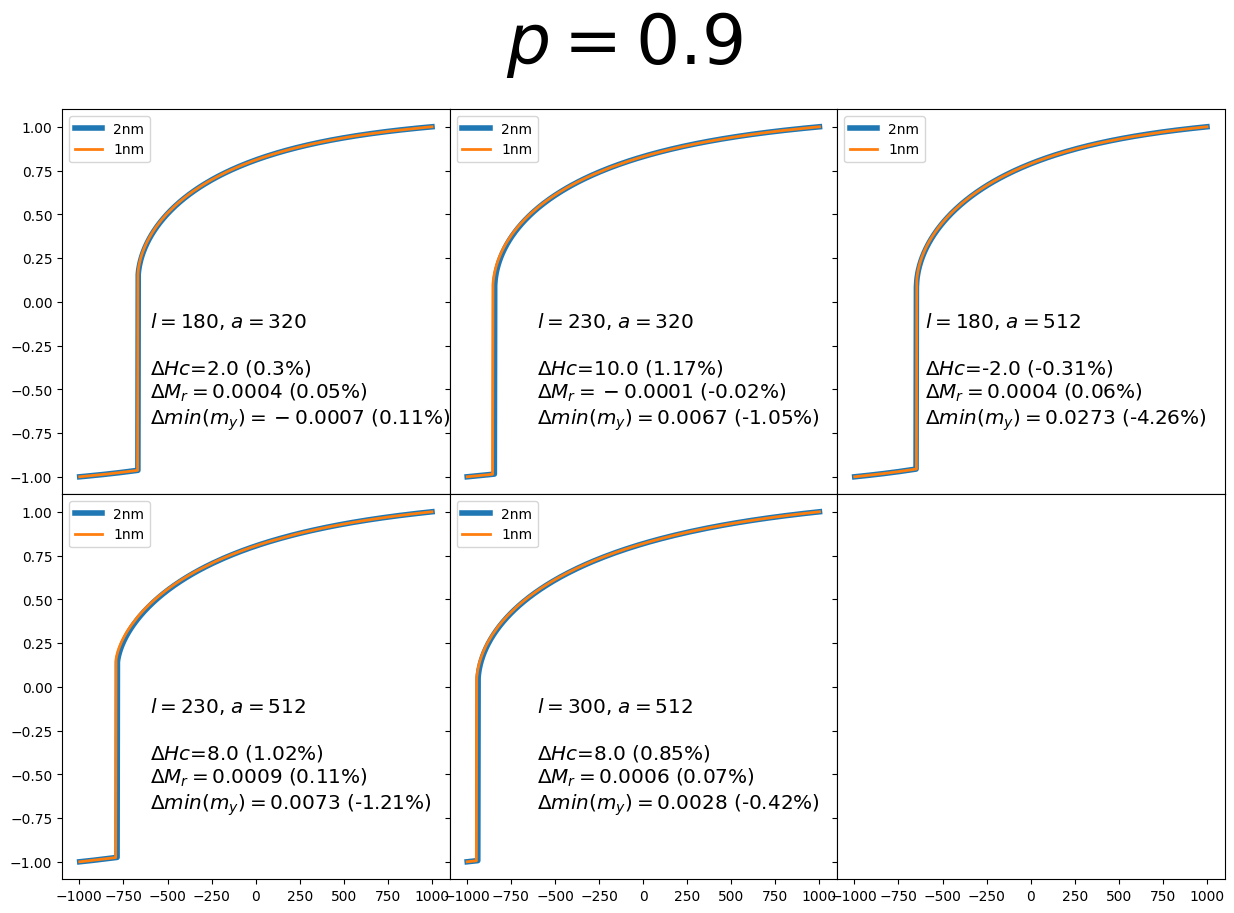

In [119]:


for pointiness in pointinessVals:
    fig, axs = plt.subplots(2,3,sharex=True,sharey=True)
    fig.set_size_inches(15,10)
    plt.subplots_adjust(wspace=0, hspace=0)

    axI=-1

    for spacing in spacingVals:
        for length in lengthVals:
            runs=getRuns(spacing,pointiness,length)
            runs = [run for run in runs if run.attrs["res"]!=4e-9]

            if len(runs)==0:
                continue
            else:
                axI+=1
                ax=axs.flatten()[axI]
            
            run2nm = [run for run in runs if run.attrs["res"]==2e-9][0]
            run1nm = [run for run in runs if run.attrs["res"]==1e-9][0]
            ax.plot(run2nm["H"],run2nm["m"],label="2nm",lw=4)
            ax.plot(run1nm["H"],run1nm["m"],label="1nm",lw=2)
            
            dHc=run1nm.attrs["Hc"]-run2nm.attrs["Hc"]
            dMr=run1nm.attrs["Br"]-run2nm.attrs["Br"]
            dMy=min(run1nm["hIsland_my"])-min(run2nm["hIsland_my"])

            HcPerc=round(dHc/runs[0].attrs["Hc"]*100,2)
            MrPerc=round(dMr/runs[0].attrs["Br"]*100,2)
            MyPerc=round(dMy/min(runs[0]["hIsland_my"])*100,2)
            ax.text(-600,-0.7,f"$l={round(length*1e9)}$, $a={round(spacing*1e9)}$\n\n$\Delta Hc$={dHc} ({HcPerc}%)\n$\Delta M_r = {round(dMr,4)}$ ({MrPerc}%)\n$\Delta min (m_y) = {round(dMy,4)}$ ({MyPerc}%)",size="x-large")
            
        
            #plt.legend()
            ax.legend()
    plt.suptitle(f"$p={pointiness}$",size=50)
    plt.savefig(f"{pointiness}.png",bbox_inches="tight")
    plt.show()
